In [2]:
import cv2 
import glob

import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

In [3]:
test_img_car = cv2.imread("../data/car/KITTI_extracted/1.png")
test_img_not_car = cv2.imread("../data/non_car/Extras/extra1.png")

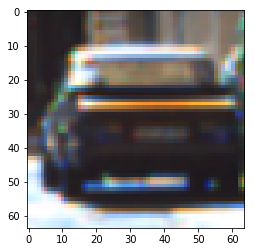

In [4]:
plt.imshow(test_img_car)
plt.show()

In [5]:
car_imgs = glob.glob("../data/car/**/*.png")
non_car_imgs = glob.glob("../data/non_car/**/*.png")
print("There are {0} car images and {1} non-car images.".format(len(car_imgs), len(non_car_imgs)))

There are 8792 car images and 8968 non-car images.


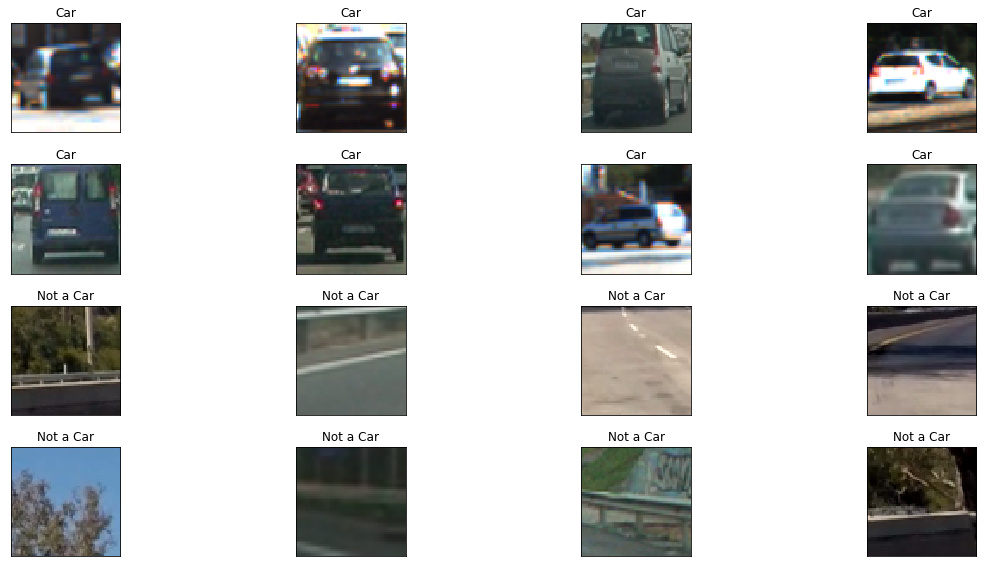

In [6]:
fig, axs = plt.subplots(4,4, figsize=(16,8))
fig.tight_layout()
axs = axs.ravel()

ixs = np.random.randint(0, len(car_imgs), 16)
for i in np.arange(8):
    tmp = cv2.cvtColor(cv2.imread(car_imgs[ixs[i]]), cv2.COLOR_BGR2RGB)
    axs[i].imshow(tmp)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title("Car")
for i in np.arange(8, 16):
    tmp = cv2.cvtColor(cv2.imread(non_car_imgs[ixs[i]]), cv2.COLOR_BGR2RGB)
    axs[i].imshow(tmp)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title("Not a Car")   
    
fig.savefig("./output_images/examples.png")

In [7]:
def color_transform(img, color_channel="LUV"):
    if color_channel == "LUV":
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_channel == 'YCrCb':
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif color_channel == 'HSV':
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_channel == 'YUV':
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_channel == 'HLS':
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    else:
        tmp = np.copy(img)
    return tmp

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, channels=[0,1,2], raveled=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        hog_features = []
        for channel in channels:
            features = hog(img[:, :, channel], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
            if raveled is True:
                hog_features.append(features.ravel())
            else:
                hog_features.append(features)
        return_features = np.concatenate(hog_features)
        return return_features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

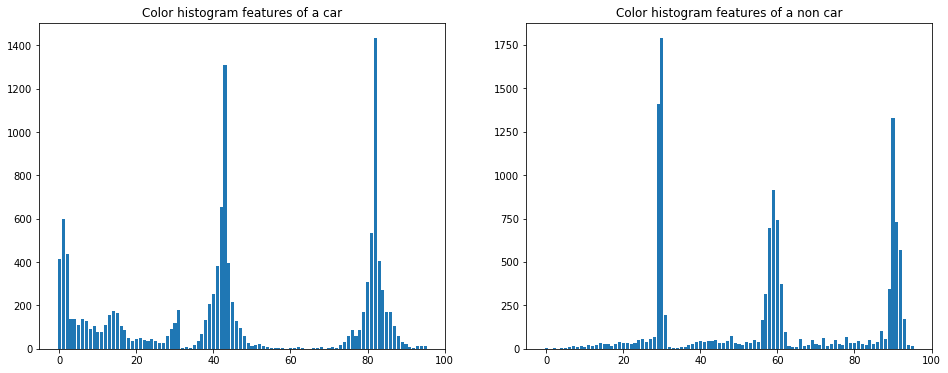

In [8]:
test_img_car_t = color_transform(test_img_car)
test_img_not_car_t = color_transform(test_img_not_car)

color_hist_car_feat = color_hist(test_img_car_t)
color_hist_not_car_feat = color_hist(test_img_not_car_t)
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs = axs.ravel()

axs[0].bar(np.arange(color_hist_car_feat.shape[0]), color_hist_car_feat)
axs[0].set_title("Color histogram features of a car")
axs[1].bar(np.arange(color_hist_car_feat.shape[0]), color_hist_not_car_feat)
axs[1].set_title("Color histogram features of a non car")
fig.savefig("./output_images/color_hist.png")

In [9]:
car_hog, car_hog_pic = get_hog_features(test_img_car_t[:, :, 0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
not_car_hog, not_car_hog_pic = get_hog_features(test_img_not_car_t[:, :, 0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True)


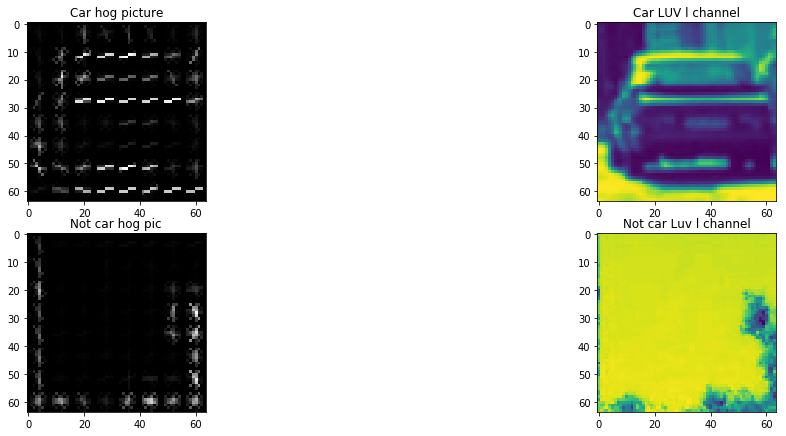

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16,6))
axs = axs.ravel()
fig.tight_layout()

axs[0].imshow(car_hog_pic, "gray")
axs[0].set_title("Car hog picture")
axs[1].imshow(test_img_car_t[:, :, 0])
axs[1].set_title("Car LUV l channel")


axs[2].imshow(not_car_hog_pic, "gray")
axs[2].set_title("Not car hog pic")
axs[3].imshow(test_img_not_car_t[:, :, 0])
axs[3].set_title("Not car Luv l channel")
fig.savefig("./output_images/hog_luv.png")

In [11]:
def process_image(tmp, color_channel, color_hog_channel,
                 orient, pix_per_cell, cell_per_block, hog=True):
    features = []
    tmp_original = np.copy(tmp)
    tmp = color_transform(tmp, color_channel=color_channel)
    features.append(bin_spatial(tmp).ravel())
    features.append(color_hist(tmp).ravel())
    if hog is True:
        features.append(get_hog_features(tmp, orient=orient, pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     channels=color_hog_channel).ravel())
    features_all = np.concatenate(features)
    return features_all

In [12]:
def process_all(img_paths, color_channel = "YUV", color_hog_channel=[0, 1, 2],
                 orient=11, pix_per_cell=8, cell_per_block=2):
    features_to_ret = []
    for img in img_paths:
        tmp = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        features_to_ret.append(process_image(tmp, color_channel="YUV", color_hog_channel=color_hog_channel,
                                            orient=orient, pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block))
    
    return features_to_ret

In [13]:
car_features = process_all(car_imgs)
non_car_features = process_all(non_car_imgs)

In [14]:
# Put together all images
car_X = np.vstack(car_features)
non_car_X = np.vstack(non_car_features)

In [15]:
# Creating labels
Y = np.concatenate([np.ones(car_X.shape[0]), np.zeros(non_car_X.shape[0])])
X = np.concatenate([car_X, non_car_X])

In [16]:
print("Feature length: {}".format(X.shape[1]))

Feature length: 9636


In [17]:
# Random splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=14, shuffle=True, test_size=0.25)

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [20]:
#svc = SVC(kernel="rbf", C=1)
lin_svc = LinearSVC()
#parameters = {'C':[1, 3, 10]}

In [21]:
#clf = GridSearchCV(svc, parameters)
#clf.fit(X_train, y_train)

In [22]:
lin_svc.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [23]:
lin_svc.score(X_test_scaled, y_test)

0.9900900900900901

In [24]:
ab = AdaBoostClassifier()

In [25]:
#ab.fit(X_train_scaled, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [26]:
#ab.score(X_test_scaled, y_test)

0.9842342342342343

## Sliding window and cars on the image

In [27]:
# Function from class
def search_windows(img, windows, clf, scaler, color_channel = "YUV",
                                color_hog_channel=[0, 1, 2],
                                orient=11,
                                pix_per_cell=8,
                                cell_per_block=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        tmp_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = process_image(tmp_img, color_channel = color_channel,
                                color_hog_channel=color_hog_channel,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [28]:
test_img_road = cv2.cvtColor(cv2.imread("./test_images/test1.jpg"), cv2.COLOR_BGR2RGB)

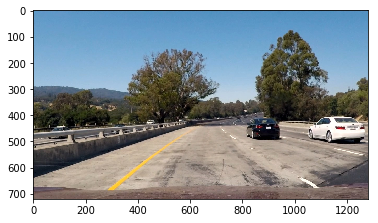

In [29]:
plt.imshow(test_img_road)

In [121]:
color_channel = "YUV"
color_hog_channel=[0, 1, 2]
orient=11
pix_per_cell=8
cell_per_block=2

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

windows = slide_window(test_img_road, x_start_stop=[None, None], y_start_stop=[350, 700], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

In [31]:
found_windows = search_windows(test_img_road, windows, lin_svc, scaler)

In [32]:
window_img = draw_boxes(test_img_road, found_windows, color=(0, 0, 255), thick=6)                    

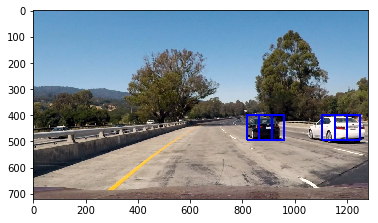

In [33]:
plt.imshow(window_img)

In [133]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             bboxes=None, draw=True, draw_all=False):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    # Changing it to YUV
    ctrans_tosearch = color_transform(img_tosearch, 'YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False,
                           channels=[0], raveled=False)
    hog2 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False,
                           channels=[1], raveled=False)
    hog3 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False,
                           channels=[2], raveled=False)
    if bboxes is None:
        bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            features = process_image(subimg, color_channel = "YUV", color_hog_channel=[0, 1, 2],
                 orient=11, pix_per_cell=8, cell_per_block=2, hog=False) 

            # Scale features and make a prediction
            features = np.concatenate([features, hog_features]).reshape(1, -1)
            test_features = X_scaler.transform(features).reshape(1, -1)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            if test_prediction == 1 or draw_all is True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bboxes
    
ystart = 400
ystop = 656
scale = 1.2
    
out_img, bboxes = find_cars(test_img_road, ystart, ystop, scale, clf=lin_svc, X_scaler=scaler,
                    orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)


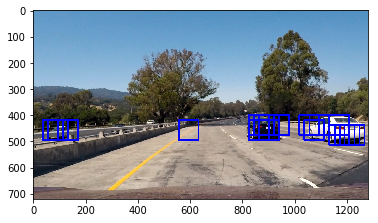

In [134]:
plt.imshow(out_img)

In [36]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

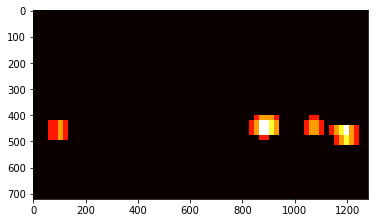

In [37]:
hm = np.zeros_like(test_img_road[:,:,0]).astype(np.float)
heat = add_heat(hm, bboxes)
heat = apply_threshold(heat, 1)
plt.imshow(heat, cmap="hot")

In [135]:
# But cars could be  seen in different sizes, so we  need  to have different bounding boxes, 
# so we need differnent scales for different start positions
# Credit to https://github.com/tatsuyah for the starting positions
pos_and_scale = np.array([[400, 464, 1.0],
                [400, 500, 1.3],
                [420,496,1.5],
                [432,528,1.5],
                [430,556,2.],
                [400,528,2.0],
                [432,560,2.0],
                [500,656,3.0],
                [490,596,3.5],
                [464,660,3.5]])
bbox = []
for pos in pos_and_scale:
    out_img, bbox = find_cars(test_img_road, ystart=int(pos[0]), ystop=int(pos[1]), scale=pos[2], clf=lin_svc, X_scaler=scaler,
                     orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32,
                              bboxes=bbox,
                               draw=False)

    

In [140]:
# Draw rectangles:
pos_and_scale = np.array([[400, 464, 1.0],
                [400, 500, 1.3],
                [420,496,1.5],
                [432,528,1.5],
                [430,556,2.],
                [400,528,2.0],
                [432,560,2.0],
                [500,656,3.0],
                [490,596,3.5],
                [464,660,3.5]])
bbox = []
for pos in pos_and_scale:
    out_img, bbox = find_cars(test_img_road, ystart=int(pos[0]), ystop=int(pos[1]), scale=pos[2], clf=lin_svc, X_scaler=scaler,
                     orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32,
                              bboxes=bbox,
                               draw=True, draw_all=True)
    out_img = draw_boxes(out_img, bbox)
    

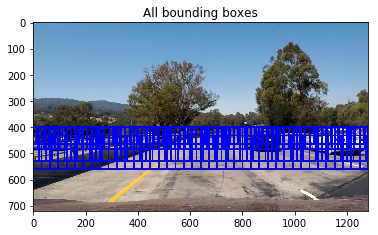

In [146]:
plt.imshow(out_img)
plt.title("All bounding boxes")
plt.imsave("./output_images/all_bounding.png", out_img)

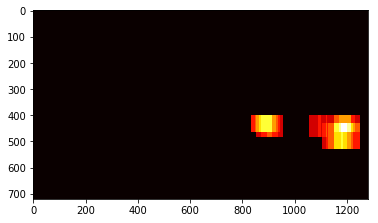

In [110]:
hm = np.zeros_like(test_img_road[:,:,0]).astype(np.float)
heat = add_heat(hm, bbox)
heat = apply_threshold(heat, 2)
plt.imshow(heat, cmap="hot")

In [111]:
def find_car_full(img, threshold=1):
    pos_and_scale = np.array([
                [400, 464, 1.0],
                [400, 500, 1.3],
                [420,496,1.5],
                [432,528,1.5],
                [430,556,2.],
                [400,528,2.0],
                [432,560,2.0],
                [500,656,3.0],
                [490,596,3.5],
                [464,660,3.5]])
    bbox = []
    for pos in pos_and_scale:
        _, bbox = find_cars(img, ystart=int(pos[0]), ystop=int(pos[1]), scale=pos[2], clf=lin_svc, X_scaler=scaler,
                        orient=11, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32,
                                  bboxes=bbox,
                                  draw=False)
    hm = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(hm, bbox)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    
    return  heatmap

In [112]:
test_imgs = glob.glob("./test_images/*.jpg")

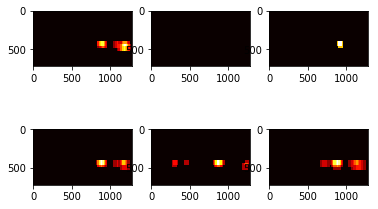

In [113]:
fig, axs = plt.subplots(2, 3)
axs = axs.ravel()
for ix, pic_path in enumerate(test_imgs):
    tmp = cv2.cvtColor(cv2.imread(pic_path), cv2.COLOR_BGR2RGB)
    tmp_heat = find_car_full(tmp)
    axs[ix].imshow(tmp_heat, "hot")

fig.savefig("./output_images/thresholded_heatmaps")

In [114]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [115]:
labels = label(tmp_heat)

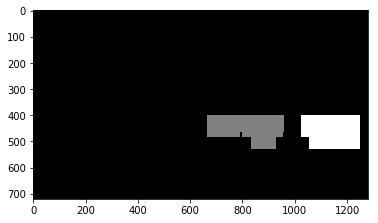

In [116]:
plt.imshow(labels[0], cmap="gray")

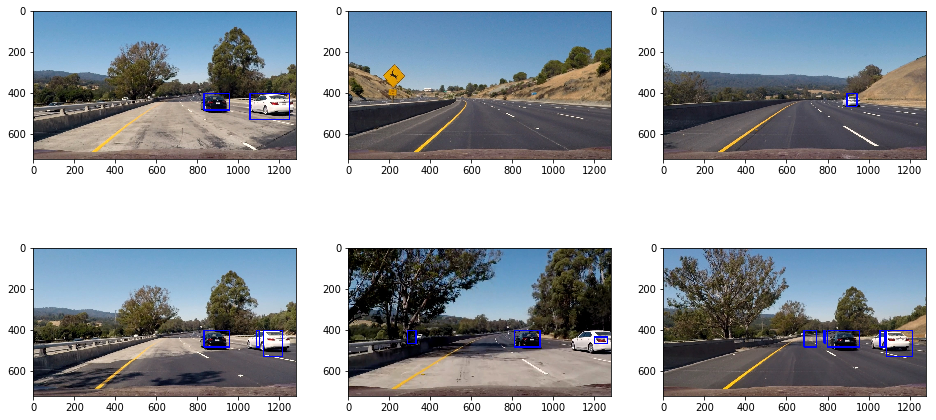

In [120]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = axs.ravel()
for ix, pic_path in enumerate(test_imgs):
    tmp = cv2.cvtColor(cv2.imread(pic_path), cv2.COLOR_BGR2RGB)
    tmp_heat = find_car_full(tmp,2)
    labels = label(tmp_heat)
    draw_img = draw_labeled_bboxes(np.copy(tmp), labels)
    axs[ix].imshow(draw_img)
    
fig.savefig("./output_images/boxes.jpg")

In [48]:
from collections import deque

In [104]:
previous_frames = deque(maxlen=10)

In [105]:
def find_car_video(img):
    hm = find_car_full(img, 3)
    previous_frames.append(hm)
    full_hm = np.zeros_like(hm)
    for prev_frame in previous_frames:
        full_hm += prev_frame
    labels = label(full_hm)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [106]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [107]:
white_output = './output_images/project_vid.mp4'
#clip1 = VideoFileClip("../project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(find_car_video) #NOTE:this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video ./output_images/project_vid.mp4
[MoviePy] Writing video ./output_images/project_vid.mp4



  5%|████▎                                                                           | 67/1261 [01:24<27:19,  1.37s/it]


 11%|████████▍                                                                      | 135/1261 [02:48<22:32,  1.20s/it]


 16%|████████████▋                                                                  | 203/1261 [04:09<21:25,  1.22s/it]


 21%|████████████████▉                                                              | 271/1261 [05:32<20:06,  1.22s/it]


 27%|█████████████████████▏                                                         | 339/1261 [06:58<18:24,  1.20s/it]


 32%|█████████████████████████▍                                                     | 407/1261 [08:20<17:05,  1.20s/it]


 38%|█████████████████████████████▊                                                 | 475/1261 [09:41<15:31,  1.19s/it]


 43%|██████████████████████████████████                                             | 543/1261 [11:02<14:19,  1.20s/it]


 48%|██████████████████████████████████████▎                                        | 611/1261 [12:24<12:55,  1.19s/it]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [13:46<11:41,  1.21s/it]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [15:07<10:14,  1.20s/it]


 65%|███████████████████████████████████████████████████                            | 815/1261 [16:28<08:50,  1.19s/it]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [17:51<07:31,  1.19s/it]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [19:34<06:44,  1.30s/it]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [21:13<05:31,  1.37s/it]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [23:03<03:58,  1.37s/it]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [24:42<02:10,  1.23s/it]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [26:12<00:50,  1.32s/it]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:03<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_vid.mp4 

Wall time: 27min 5s


In [108]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))